In [1]:
import pprint
import json
from pathlib import Path

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import anatools.data as data
import anatools.analysis as ana

from hhdm_analysis.utils import signal_label, stack_sorting, position, process_signals

ana.start()
plt.style.use("default")

# Setup config

In [2]:
period = '18'
year_style = 2018
dataset_year = "2018"
basedir = "/home/gamoreir/SanDisk/physics/hhdmAnalysis_deepJet_Regions/datasets"

# Setup output folders
dataset_name = basedir.split('/')[-2]
plots_path = f"./figures/{dataset_name}/{dataset_year}"
available_region_ids = [0,1,2,3,4]
for available_region_id in available_region_ids:
    Path(f"{plots_path}/regionID={available_region_id}").mkdir(parents=True, exist_ok=True)

# Read metadata

In [3]:
with open("../metadata.json", "r") as f:
    metadata = json.load(f)

ST = metadata.get("datasets").get("ST")
TT = metadata.get("datasets").get("TT")
ZZ = metadata.get("datasets").get("ZZ")
WZ = metadata.get("datasets").get("WZ")
DY = metadata.get("datasets").get("DY")
RESIDUAL = metadata.get("datasets").get("RESIDUAL")
DATA = metadata.get("datasets").get("DATA")

# Load datasets

In [4]:
ds = data.read_files(basedir, period, mode="normal")

data.join_datasets(ds, "ST", ST.get(period), mode="normal")
data.join_datasets(ds, "TT", TT.get(period), mode="normal")
data.join_datasets(ds, "ZZ", ZZ.get(period), mode="normal")
data.join_datasets(ds, "WZ", WZ.get(period), mode="normal")
data.join_datasets(ds, "DYJetsToLL", DY.get(period), mode="normal")
data.join_datasets(ds, "Residual", RESIDUAL.get(period), mode="normal")
data.join_datasets(ds, "Data", DATA.get(period), mode="normal")

print("Signal_400_100", ds["Signal_400_100"].shape)
print("Signal_1000_100", ds["Signal_1000_100"].shape)
print("ST", ds["ST"].shape)
print("TT", ds["TT"].shape)
print("ZZ", ds["ZZ"].shape)
print("WZ", ds["WZ"].shape)
print("DYJetsToLL", ds["DYJetsToLL"].shape)
print("Residual", ds["Residual"].shape)
print("Data", ds["Data"].shape)


Loading datasets...


100%|██████████| 73/73 [00:14<00:00,  4.96it/s]


Signal_400_100 (112655, 43)
Signal_1000_100 (184662, 43)
ST (94330, 43)
TT (2647163, 43)
ZZ (1924672, 43)
WZ (24816, 43)
DYJetsToLL (5897214, 45)
Residual (537577, 43)
Data (456382, 43)


# Update datasets with evtWeight_nobtag

In [5]:
for dataset_name, dataset_df in ds.items():
    dataset_df.loc[:, 'evtWeight_nobtag'] = (dataset_df.evtWeight / dataset_df.btag_wgt).reset_index(drop=True)

# Prepare dataset to plot

In [6]:
region_id = 2 # TTBar control region
colors_list = ["gainsboro", "orchid", "limegreen", "red", "skyblue", "darkgoldenrod"]
labels_list = [r"Residual SM", r"$WZ$", r"$ZZ$", "Single top", r"$t\bar{t}$", "Drell-Yan"]
bkg_list = ["Residual", "WZ", "ZZ", "ST", "TT", "DYJetsToLL"]
ds = {k: v[v.RegionID == region_id] for k,v in ds.items()}
dataframes, labels, colors = stack_sorting(ds, colors_list, labels_list, bkg_list)

      Datasets  Number of events
0  Residual SM        871.489438
1         $ZZ$          3.605530
2         $WZ$         52.716884
3    Drell-Yan         87.309033
4   Single top       7583.205803
5   $t\bar{t}$      55143.198227
Purity: 0.8651063541514493


# Plot b-jet multiplicity without b-tagging corrections

/mnt/wsl/PHYSICALDRIVE2/Physics/masters_research/workspace/hhdmAnalysis/.venv/lib/python3.8/site-packages/anatools/analysis/plots.py:212: RuntimeWarning: invalid value encountered in true_divide
  yl = (yden - errden)/yden
/mnt/wsl/PHYSICALDRIVE2/Physics/masters_research/workspace/hhdmAnalysis/.venv/lib/python3.8/site-packages/anatools/analysis/plots.py:213: RuntimeWarning: invalid value encountered in true_divide
  yh = (yden + errden)/yden
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


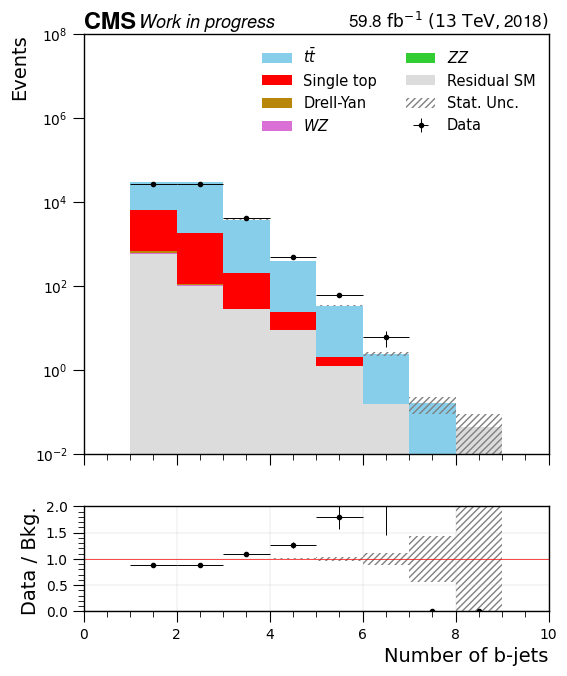

In [7]:
# Var
var = "Nbjets"
bins = np.linspace(0, 10, 11)
xlabel = "Number of b-jets"

# Plot config
fig = plt.figure(figsize=(6,7.5))
grid = [2,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[4, 1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number

ybkg, errbkg = ana.stacked_plot(ax1, var, dataframes, labels, colors, weight="evtWeight_nobtag", bins=bins)
ydata, errdata = ana.data_plot(ax1, var, ds["Data"], bins=bins)

ana.labels(ax1, ylabel="Events")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=True, legend_ncol=2, ylim=[1.e-2,1.e8], xticklabels=False
)

# Sub plot
ax2 = plt.subplot(position(gspec, grid, main=1, sub=2)) # main is column number, sub is row number
ana.ratio_plot( ax2, ydata, errdata, ybkg, errbkg, bins=bins)
ana.labels(ax2, xlabel=xlabel, ylabel="Data / Bkg.")
ana.style(ax2, ylim=[0., 2], yticks=[0, 0.5, 1, 1.5, 2], xgrid=True, ygrid=True)

plt.savefig(f"{plots_path}/regionID={region_id}/{var}_noCorrections.png", dpi=200, facecolor='white')
plt.show()
plt.close()


# Plot b-jet multiplicity with b-tagging corrections

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


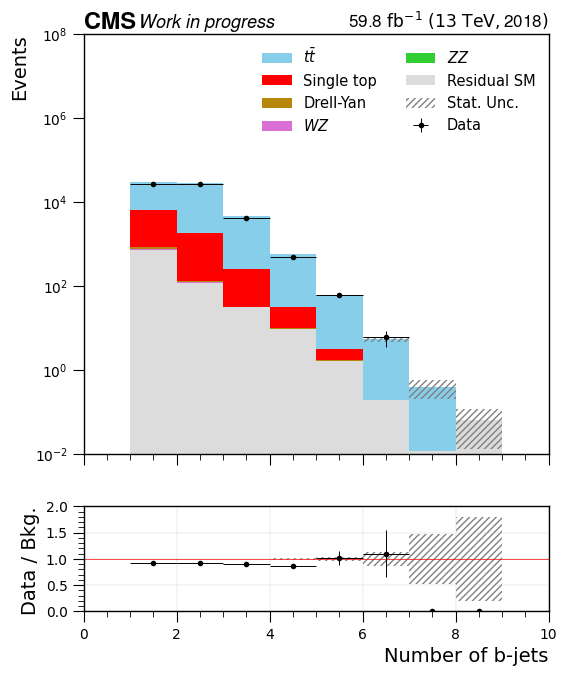

In [8]:
# Var
var = "Nbjets"
bins = np.linspace(0, 10, 11)
xlabel = "Number of b-jets"

# Plot config
fig = plt.figure(figsize=(6,7.5))
grid = [2,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[4, 1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number

ybkg, errbkg = ana.stacked_plot(ax1, var, dataframes, labels, colors, weight="evtWeight", bins=bins)
ydata, errdata = ana.data_plot(ax1, var, ds["Data"], bins=bins)

ana.labels(ax1, ylabel="Events")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=True, legend_ncol=2, ylim=[1.e-2,1.e8], xticklabels=False
)

# Sub plot
ax2 = plt.subplot(position(gspec, grid, main=1, sub=2)) # main is column number, sub is row number
ana.ratio_plot( ax2, ydata, errdata, ybkg, errbkg, bins=bins)
ana.labels(ax2, xlabel=xlabel, ylabel="Data / Bkg.")
ana.style(ax2, ylim=[0., 2], yticks=[0, 0.5, 1, 1.5, 2], xgrid=True, ygrid=True)

plt.savefig(f"{plots_path}/regionID={region_id}/{var}.png", dpi=200, facecolor='white')
plt.show()
plt.close()
